# Bytes

In [ ]:
print(1)

In [2]:
import numpy as np
mapping = {}
for i in range(1000):
    i_str = f'{i:03}'
    mapping[i_str] = i
mapping["010"] = 20
mapping["101"] = 102
    
def pixel_to_char(pixel):
    pixel = np.array(pixel) // 26
    pixel = "".join([str(x) for x in pixel])
    pixel_value = mapping[pixel]
    pixel_char = chr(pixel_value)
    return pixel_char

In [3]:
pixel_to_char([255,255,255])

'ϧ'

# Images

In [9]:
import glob
paths = glob.glob("./data/celeba_aligned_with_mtcnn/*.jpg")

In [10]:
len(paths)

202303

In [11]:
print(1)

1


In [12]:
paths[0]

'./data/celeba_aligned_with_mtcnn/052628.jpg'

In [13]:
SQUEEZE = 2
from PIL import Image
import numpy as np
im_array = np.array(Image.open(paths[2]))[::SQUEEZE,::SQUEEZE]

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

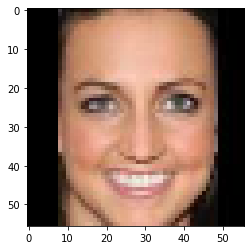

In [15]:
plt.imshow(im_array)

In [16]:
im_array.shape

(56, 56, 3)

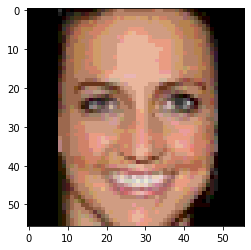

In [17]:
plt.imshow(((im_array // 26) * 26).astype(int))

In [18]:
np.max(im_array // 26)

9

In [19]:
len(paths)

202303

In [ ]:
from tqdm import tqdm
with open(f"data/faces_color_{SQUEEZE}.txt","a") as f:
    for i in tqdm(range(len(paths))):
        im_array = np.array(Image.open(paths[i]))[::SQUEEZE,::SQUEEZE]
        im_list = list(im_array)
        for line in im_list:
            line = [pixel_to_char(x) for x in line]
            f.write("".join(line))
            f.write("\n")
        f.write("e")
        # break

 55%|█████▌    | 111848/202303 [29:00<23:33, 64.01it/s]

In [ ]:
print(1)

In [ ]:
SQUEEZE = 2
VOCAB_SIZE = 30000
from tokenizers import ByteLevelBPETokenizer
files = [f"data/faces_color_{SQUEEZE}.txt"]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=files, vocab_size=VOCAB_SIZE)

# Save files to disk


In [ ]:
tokenizer.save_model(".", f"tokenizer-faces_color-{SQUEEZE}-{VOCAB_SIZE}")

# GPT training

In [2]:
SQUEEZE = 1
VOCAB_SIZE = 30000
import torch
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer(vocab_file = f"tokenizer-faces_color-{SQUEEZE}-{VOCAB_SIZE}-vocab.json",
                          merges_file = f"tokenizer-faces_color-{SQUEEZE}-{VOCAB_SIZE}-merges.txt"
                         )

In [5]:
len(tokenizer.get_vocab())

30000

In [6]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [12]:
eos_id = tokenizer.encode("e")[0]

In [14]:
# eos_id = 68
eos_id = tokenizer.encode("e")[0]

In [15]:
from transformers import GPT2Model, GPT2Config

N_TOKENS = 1024 * 5

configuration = GPT2Config(vocab_size = VOCAB_SIZE,
                           n_positions = N_TOKENS,
                           n_embd = 1024,
                           n_layer = 8,
                           n_head = 4,
                           n_inner = None,
                           activation_function = 'gelu_new',
                           resid_pdrop = 0., #0.1,
                           embd_pdrop = 0.,
                           attn_pdrop = 0.,
                           layer_norm_epsilon = 1e-05,
                           initializer_range = 0.02,
                           summary_type = 'cls_index',
                           summary_use_proj = True,
                           summary_activation = None,
                           summary_proj_to_labels = True,
                           summary_first_dropout = 0.,
                           scale_attn_weights = True,
                           use_cache = True,
                           bos_token_id = eos_id,
                           eos_token_id = eos_id,
                           scale_attn_by_inverse_layer_idx = True,
                           reorder_and_upcast_attn = False)

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration)

In [18]:
from transformers import TextDataset, DataCollatorForLanguageModeling

args = {
    "epochs": 500,
    "bs": 1 * 2,
    # "warmup": 100,
    "grad_accum": 128,
    "tokens": N_TOKENS,
    "training": True,
    "lr": 1e-4,
    "wd": 1e-3,
    
}

# Сохраним обучающие данные в .txt файл 
train_path = f"data/faces_color_{SQUEEZE}.txt"
# train_path = f'data/faces_short.txt'

# Создание датасета
train_dataset = TextDataset(
    tokenizer=tokenizer, 
    file_path=train_path, 
    block_size=args["tokens"]
)

# Создание даталодера (нарезает текст на оптимальные по длине куски)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

model.training = args["training"]

/home/jovyan/.imgenv-razzhigaev2-0/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [21]:
import torch

from transformers import Trainer, TrainingArguments

comet_ml is installed but `COMET_API_KEY` is not set.


In [164]:
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3,  4, 5, 6, 7])

In [23]:
len(train_dataset)

113788

In [25]:
training_args = TrainingArguments(
    do_train=True,
    do_eval=False,
    output_dir="./finetuned", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=args["epochs"], # number of training epochs
    per_device_train_batch_size=args["bs"], # batch size for training
    # per_device_eval_batch_size=1,  # batch size for evaluation
    # warmup_steps=args["warmup"],# number of warmup steps for learning rate scheduler
    # gradient_accumulation_steps=args["grad_accum"], # to make "virtual" batch size larger
    # label_smoothing_factor=0.1,
    # deepspeed=True,
    dataloader_num_workers=20,
    fp16 = False,
    logging_steps = 50,
    learning_rate = args["lr"],
    weight_decay = args["wd"],
    save_steps = 5000,
    # label_smoothing_factor = 1e-2
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # is_model_parallel = True
    # optimizers = (torch.optim.AdamW(model.parameters(),lr=args["lr"]),None) # Optimizer and lr scheduler
)

/home/user/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.object, string),
/home/user/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:573: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.bool, bool),
/home/user/conda/lib/python3.7/site-packages/tensorboard/util/tensor_util.py:113: DeprecationW

In [ ]:
TOKENIZERS_PARALLELISM = "true"
trainer.train()

***** Running training *****
  Num examples = 113788
  Num Epochs = 500
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3556000


Step,Training Loss
50,2.715700
100,2.724700
150,2.726300
200,2.724300
250,2.718500
300,2.726100
350,2.725100
400,2.734100
450,2.719500
500,2.719800


# Generate

In [ ]:
model = model.module

In [131]:
import numpy as np
mapping = {}
for i in range(1000):
    i_str = f'{i:03}'
    mapping[i_str] = i
mapping["010"] = 20
mapping["101"] = 102

inverse_mapping = {mapping[key]: key for key in list(mapping.keys())}

def char_to_pixel(char):
    char_value = ord(char)
    pixel_value = inverse_mapping[char_value]
    pixel = [int(s) for s in pixel_value]
    return pixel

In [161]:
device = model.device
model.train()
input_ids = torch.tensor([[eos_id]]).to(device)
with torch.no_grad():
    out = model.generate(input_ids, 
                            do_sample=True,
                            # top_k=50,
                            # top_p=0.95,
                            temperature= 2.9,
                            max_length=N_TOKENS,
                            # max_new_tokens=1024,
                            early_stopping=True,
                            num_beams = 50,
                            # num_beam_groups=30,
                            # repetition_penalty=3.,
    #                         remove_invalid_values=True,
                            # eos_token_id=0,
                            # pad_token_id=0,
                            # forced_eos_token_id=0,
                            use_cache=True,
                            # no_repeat_ngram_size = 9,
                            # length_penalty=0.8,
                            )

Setting `pad_token_id` to `eos_token_id`:68 for open-end generation.


In [162]:
generated_text = tokenizer.decode(out[0])
# print(generated_text)

(3, 114, 111)


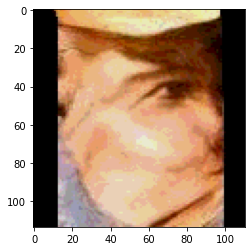

In [163]:
import numpy as np
lines = generated_text[1:-1].split("\n")
dim = round(np.mean([len(l) for l in lines]))

import torch
import torch.nn as nn

def upsample(x, dim):
    x = torch.FloatTensor(x)[None,None,None]
    
    x = (nn.Upsample(size=(1,dim))(x).squeeze() * 26)
    # print(x.shape)
    return list(x.numpy().astype(int))

image_array = []
for line in lines:
    if len(line) > 2:
        line = [char_to_pixel(x)[0] for x in line]
        line = upsample(line, dim)
        image_array.append(line)
r = image_array[:]

image_array = []
for line in lines:
    if len(line) > 2:
        line = [char_to_pixel(x)[1] for x in line]
        line = upsample(line, dim)
        image_array.append(line)
g = image_array[:]

image_array = []
for line in lines:
    if len(line) > 2:
        line = [char_to_pixel(x)[2] for x in line]
        line = upsample(line, dim)
        image_array.append(line)
b = image_array[:]

img = np.array([r,g,b])
print(img.shape)
        
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.transpose(img,(1,2,0)), cmap="gray")